In [3]:
import chart_studio.plotly

In [7]:
from netCDF4 import Dataset, num2date
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

import PIL

import datetime
import os
import chart_studio.plotly as py
import notebook

from IPython.display import display, clear_output, Image

import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from PIL import Image


In [4]:
# PATHS
cwatm_source_path = r"C:\Users\ajainf1\PycharmProjects\Sarati_CWATM\Python_Packages\source_py3\cwatm3.py"
settings_file_path = r"C:\Users\ajainf1\PycharmProjects\Sarati_CWATM\cwatm_input\settings_sarati_frontend.ini"
settings_file_path2 = r"C:\Users\ajainf1\PycharmProjects\Sarati_CWATM\cwatm_input\settings_sarati_frontend_newlanduse.ini"
command_str = 'python ' + cwatm_source_path + " " + settings_file_path2 + ' -l'

fuse_folder_github = 'C:/GitHub/FUSE'
fuse_folder_local = 'C:/FUSE'

cwatm_folder_local = fuse_folder_local + '/CWATM'

output_folder = cwatm_folder_local + '/Output' # _2019_Dec_16_1995-2015' #Output' #_2019_Dec_11_1961_2010'
measuredData_folder = fuse_folder_local + '/Data_forNotebooks'
photo_folder = fuse_folder_github + '/Images'

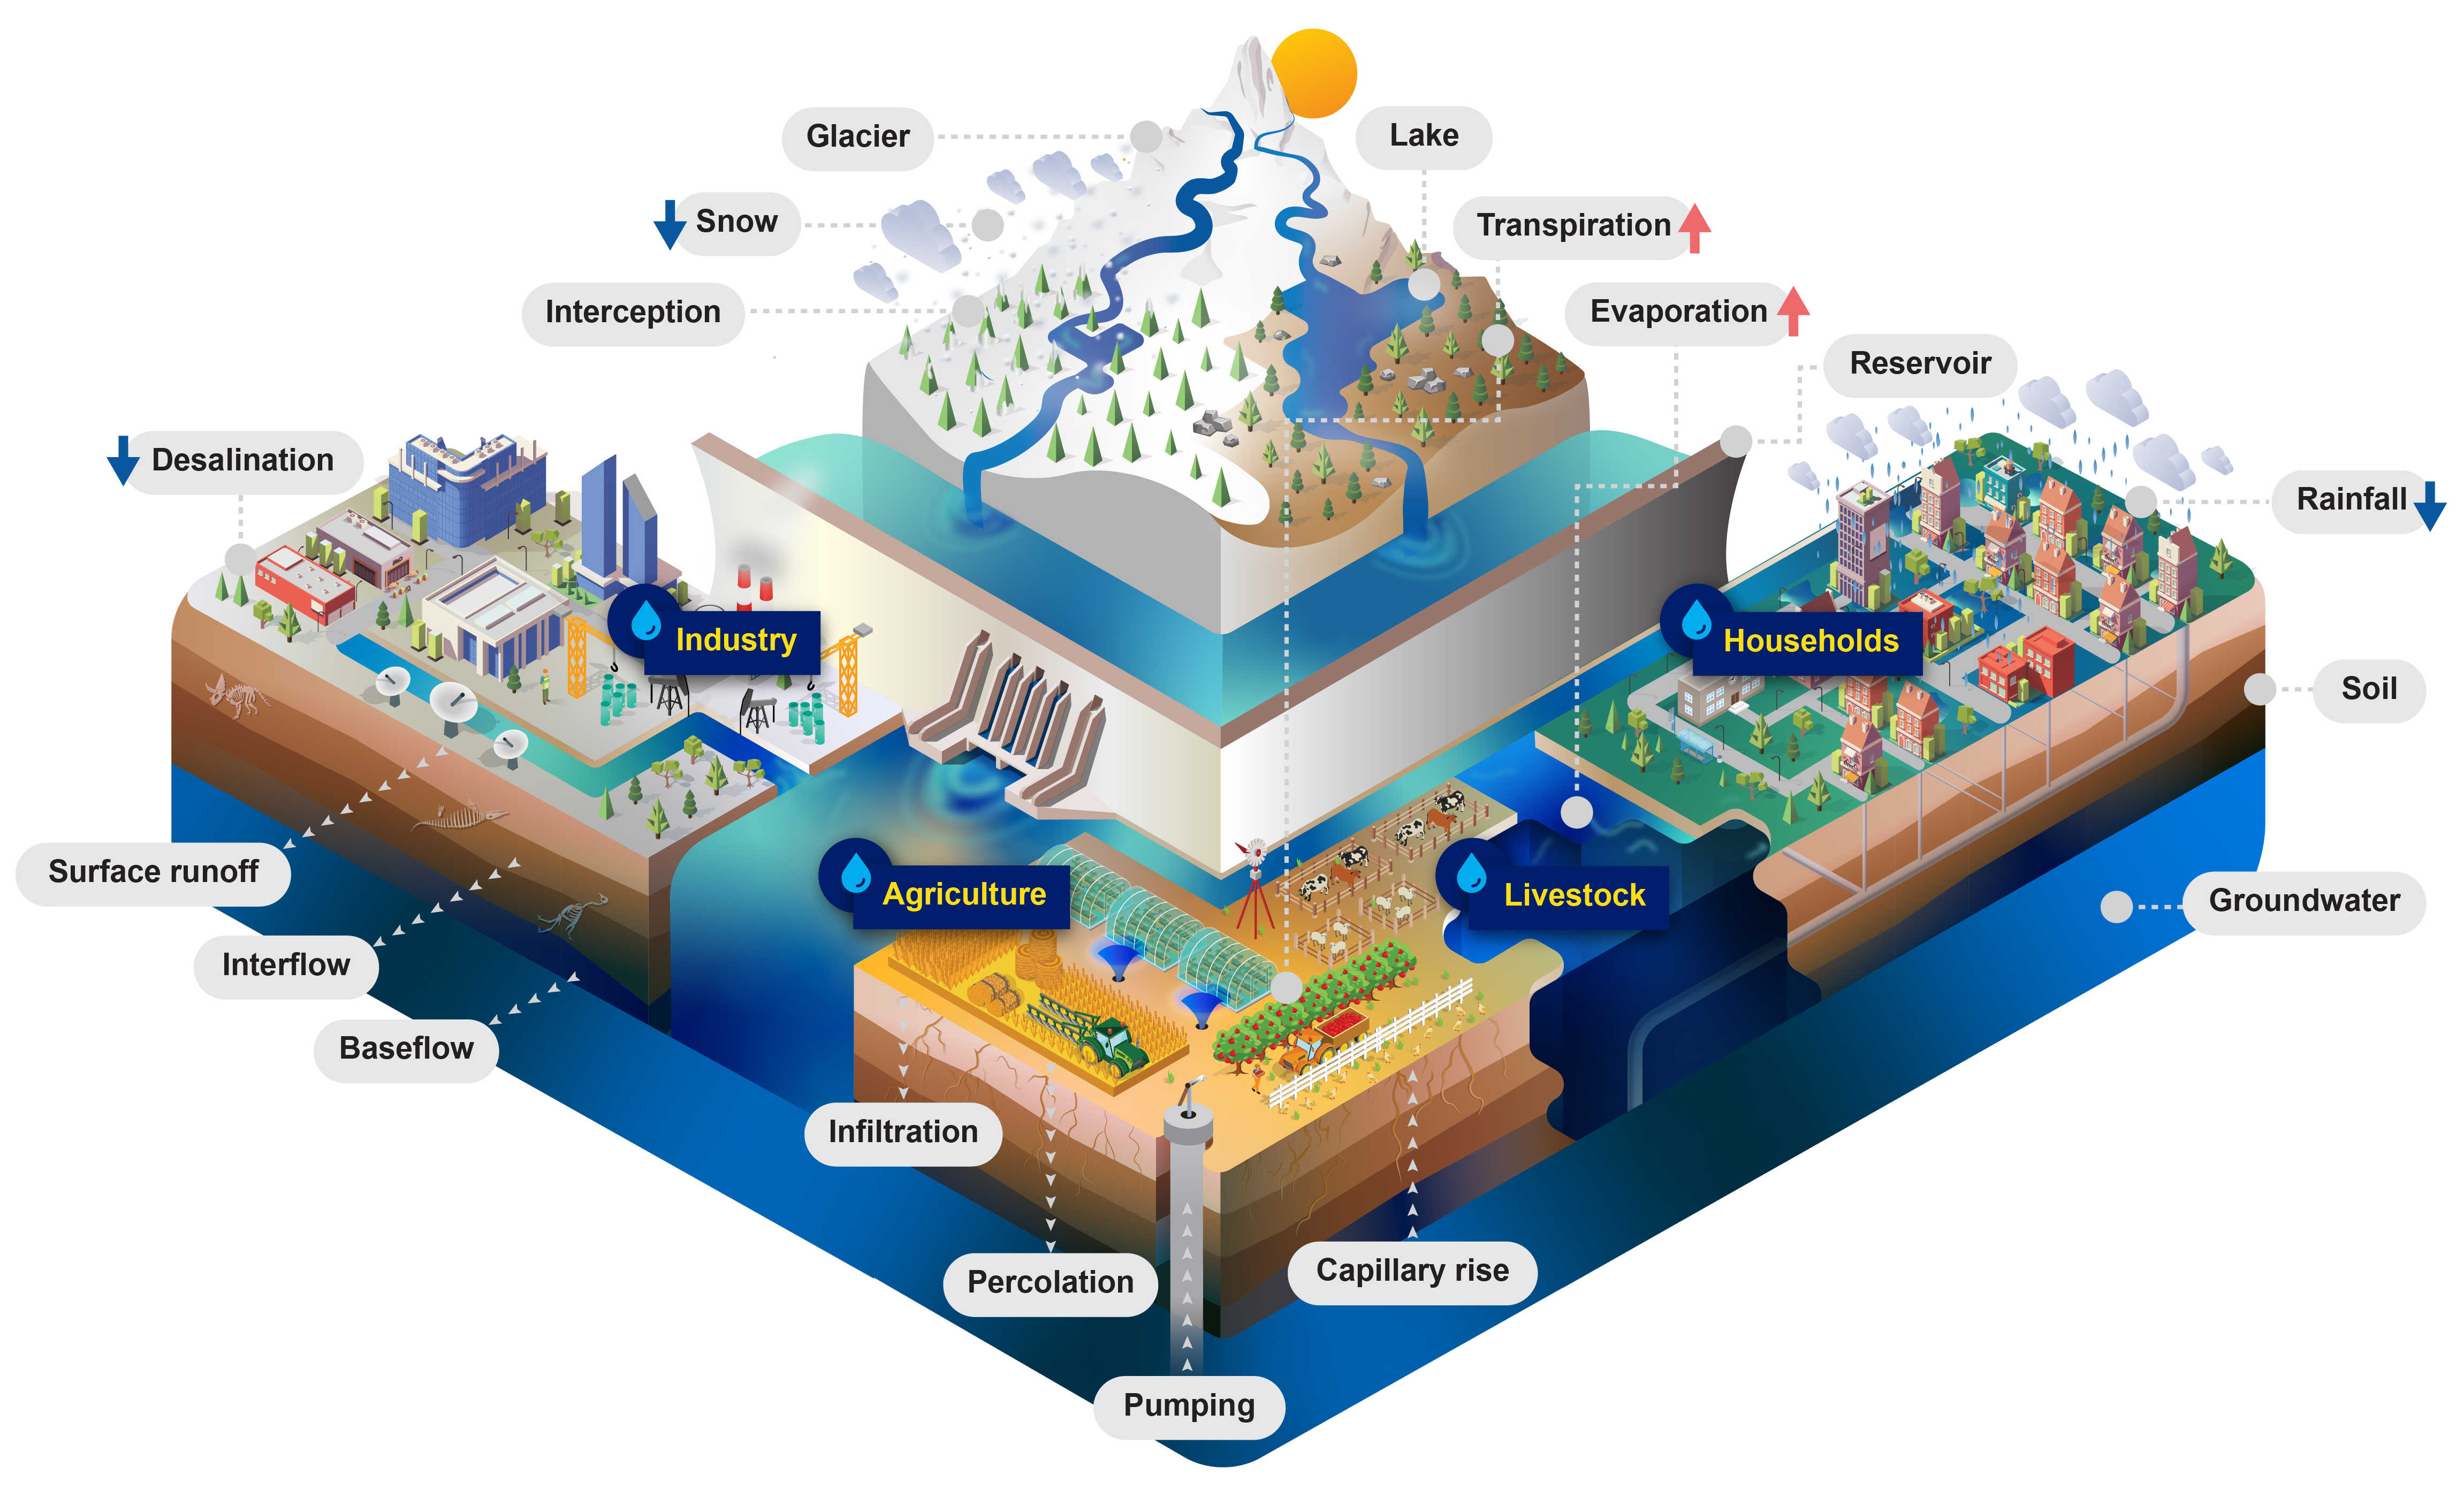

In [5]:
img = PIL.Image.open(photo_folder + '/CWatM_schematic.jpg')
img

# Change in the Landuse

In [9]:
# Map of Land use before

In [53]:
def IRR_SETTINGS(Irr_Frac=0.2):
    oldfile = open(settings_file_path, "r")
    newfile = open(settings_file_path2,"wt") 

    varnamelist = ['frontend_fracCrop_irr']
    for varname in varnamelist:
        for line in oldfile:
            if varname  in line:
                newstring = varname+ ' = ' + str(Irr_Frac)
                newfile.write(newstring)
            else:
                newfile.write(line)

        oldfile.close()
        newfile.close()
    
interact(IRR_SETTINGS, Irr_Frac=(0,1,0.1))


interactive(children=(FloatSlider(value=0.2, description='Irr_Frac', max=1.0), Output()), _dom_classes=('widge…

<function __main__.IRR_SETTINGS(Irr_Frac=0.2)>

In [54]:
#Check -- this can be hidden (not for AJF: later generalize the settings to also change dates)
varname = 'frontend_fracCrop_irr'

# OLD FILE
with open(settings_file_path, "r") as file_handle:
    file_contents = file_handle.read()
    
startloc = file_contents.find(varname)
print("old" +" - " + file_contents[startloc:startloc+len(varname)+6])

# NEWFILE
with open(settings_file_path2, "r") as file_handle:
    file_contents = file_handle.read()
file_contents.find(varname)

startloc = file_contents.find(varname)
print("new" + " - "+ file_contents[startloc:startloc+len(varname)+6])

old - frontend_fracCrop_irr = 0.5
new - frontend_fracCrop_irr = 0.4


In [59]:
def find_all_instances(file_name, text):
    with open(file_name, "r") as file_handle:
        file_contents = file_handle.read()
    
    for i in range(len(file_contents.splitlines())):
        line=file_contents.splitlines()[i]
        if text in line:
            print(str(i) + " "+line)

def replace_line(file_name, line_num, text):
    lines = open(file_name, 'r').readlines()
    lines[line_num] = text
    out = open(file_name, 'w')
    out.writelines(lines)
    out.close()

In [60]:
find_all_instances(settings_file_path2, 'StepEnd')

77 # SpinUp or StepEnd either date or numbers 
82 StepEnd = 01/02/2005 
88 #StepEnd = 31/12/2000
92 #StepEnd = 31/12/2016
93 #StepEnd = 31/12/2001


In [61]:
# Select the appropriate line number from above and replace, do -1
line_num = 82
replace_line(settings_file_path2, line_num, "StepEnd = 01/02/2005 \n" )

In [62]:
find_all_instances(settings_file_path2, 'StepEnd')

77 # SpinUp or StepEnd either date or numbers 
82 StepEnd = 01/02/2005 
88 #StepEnd = 31/12/2000
92 #StepEnd = 31/12/2016
93 #StepEnd = 31/12/2001


In [63]:
# See whole Settings file
with open(settings_file_path2, "r") as file_handle:
    file_contents = file_handle.read()

#file_contents.splitlines()

In [64]:
#Run CWATM
flag = os.system(command_str)
if flag == 0:
    print('Finished Running CWATM')

Finished Running CWATM


In [ ]:
# Map of Land use after
import xarray as xr
import numpy as np
from shapely.geometry import Point

ncfile = '/Users/Anjuli/Dropbox (MIT)/ICRISAT/GIS_Data/India JWAFS/CroplandPastureArea2000_NetCDF/Cropland2000_5min.nc'
# Ramankutty Data
ramankuttydata_krishna = xr.open_dataset(ncfile).sel(longitude=slice(73.75,80.75), latitude=slice(19.25,13.25),time=2000,level=1)
farea_krishna = ramankuttydata_krishna['farea']

# selected points from ramankutty data file
lat_med = np.transpose(np.squeeze(np.asarray(ramankuttydata_krishna['latitude'].data)))
lon_med = np.transpose(np.squeeze(np.asarray(ramankuttydata_krishna['longitude'].data)))

X, Y = np.meshgrid(lat_med, lon_med)
sh = np.shape(X);

value_mask = np.ones(sh)

# Check if points are inside the polygon domain from the shapefile # this takes a long time
for i in range(0, sh[0]):
    for j in range(0, sh[1]):
        points = [Y[i,j],X[i,j]] # long, lat
        #print(points)
        mask = poly.contains(Point(points))
        #print(mask)
        if mask == False:
            value_mask[i,j] = np.nan
        if mask == True:
            value_mask[i,j] = 1;

            
Z_mask = np.ma.masked_where(np.isnan(np.transpose(value_mask)),farea_krishna)

fig = plt.figure(figsize=(5,5))
ax  = fig.add_axes([0., 0., 1., 1., ])
m = MakeBasemap(ax)### THIS IS A FUNCTION <<<<<<<<<<<<<<<<<<<<< --- saved in my krishna functoin folder
im = m.imshow(np.flipud(Z_mask), interpolation='none',cmap=plt.cm.get_cmap('YlOrBr'), vmin=0, vmax=1)
ax.set_title("Ramankutty Croparea Fraction")
cb =m.colorbar(im,"right", size="5%", pad='2%')
plt.show()

# Results Visualization

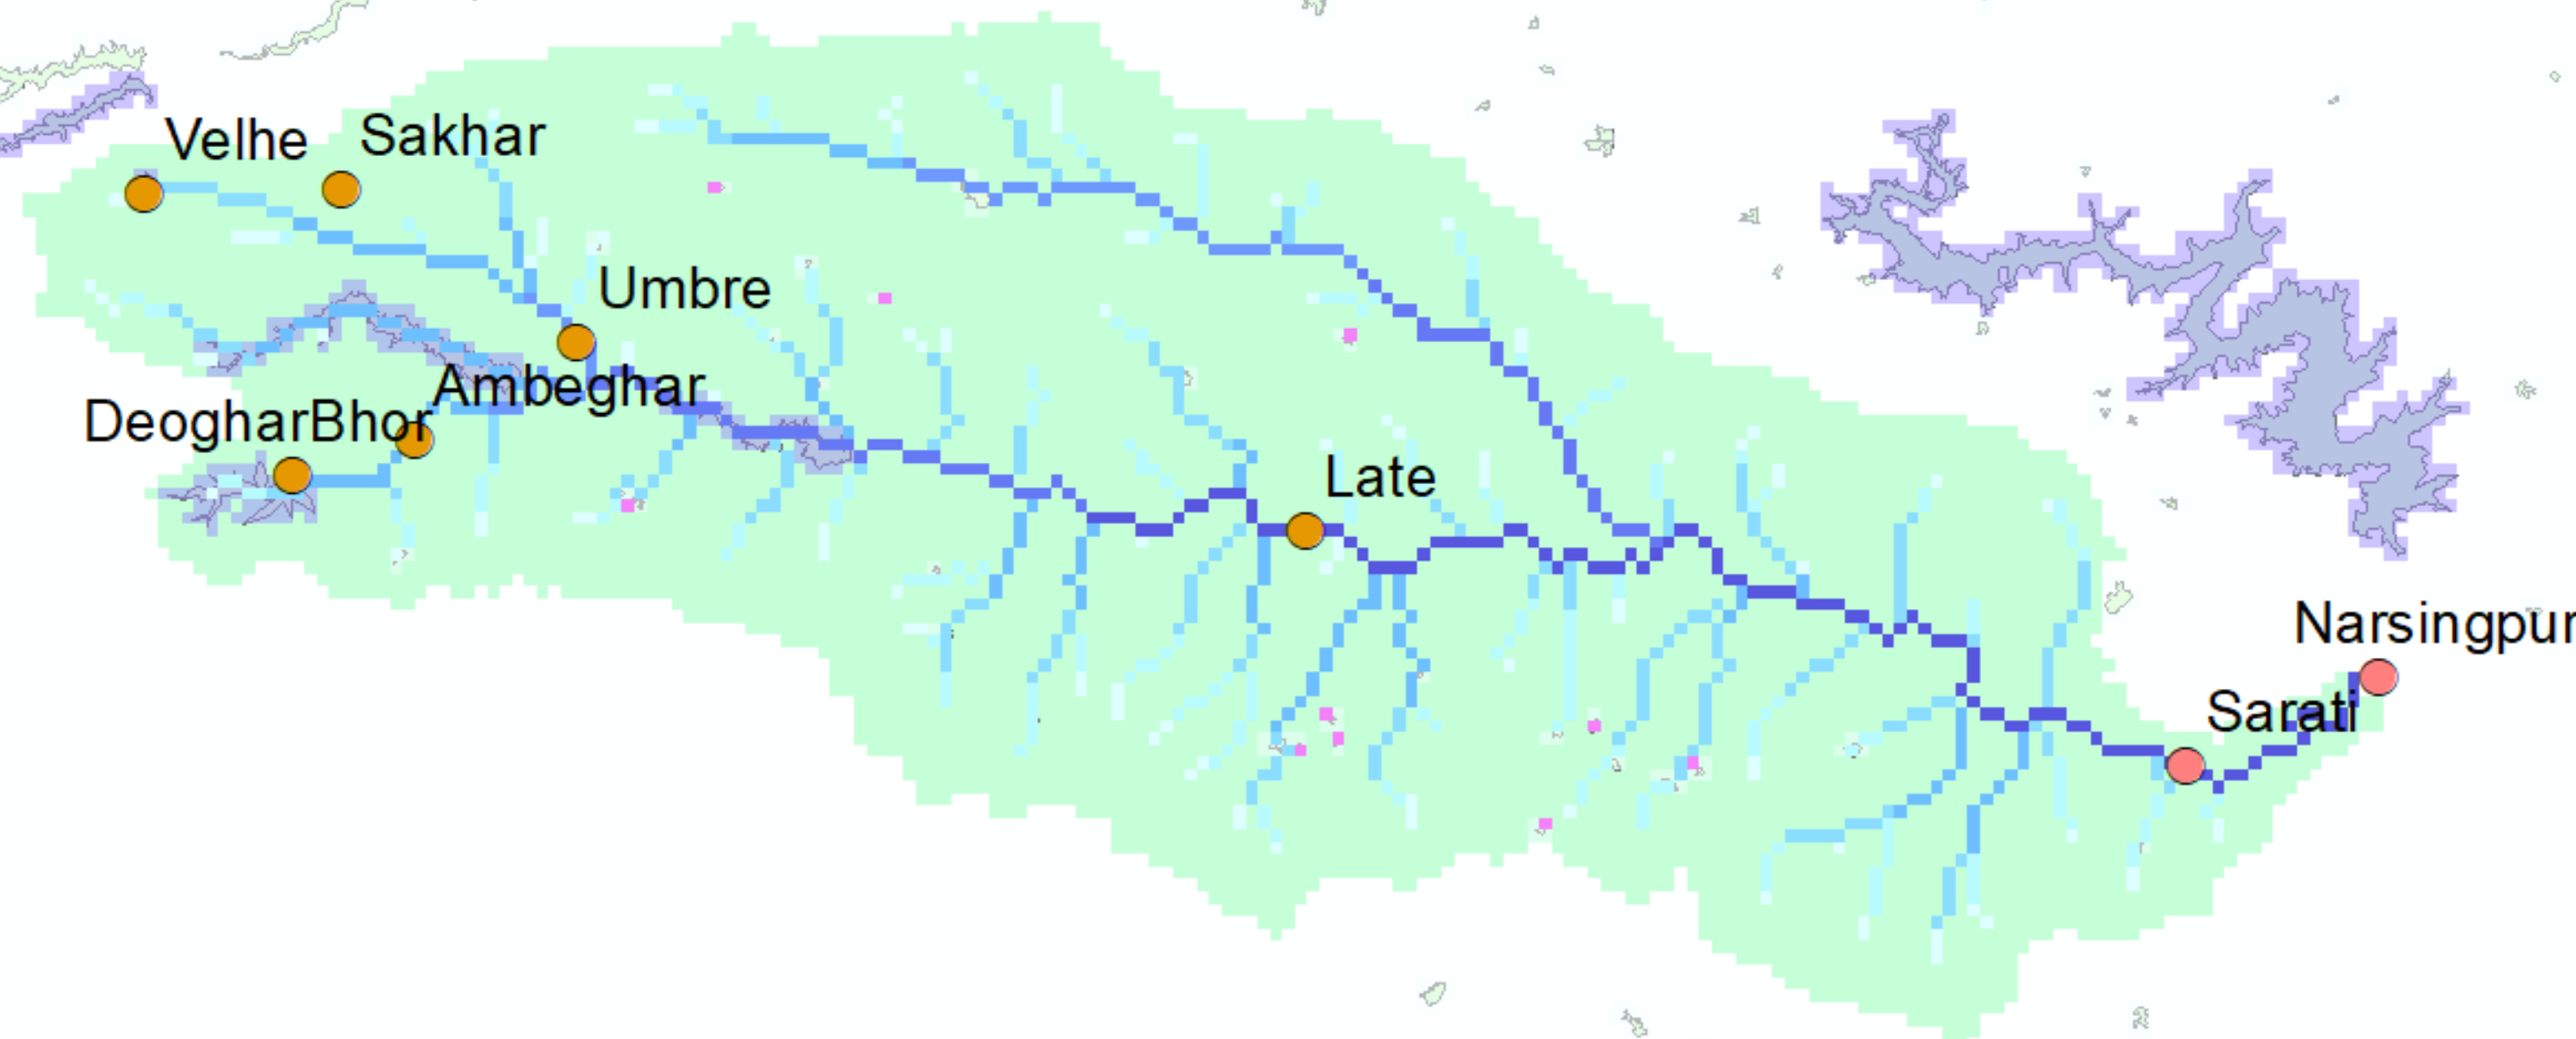

In [8]:
#Genereally from downstream to upstream

Discharge_Sarati = [('Sarati', 17.911, 75.005), 
                    ('Late', 18.0717, 74.407), 
                    ('Umbre',18.2, 73.911), 
                    ('Ambeghar', 18.133, 73.795)] #, 
                    #('Velhe', 18.3008, 73.6167)] 

                    # ('Sakhar', 18.304, 73.75)
                    # ('DeogharBhor', 18.104, 73.73)

os.listdir(photo_folder)

img = Image.open(photo_folder + '/dischargeGaugingLocations_onSarati_withFlowAccumulation.png')
img

In [9]:
observed_discharge_folder = measuredData_folder + '/River water level and discharge_Historical/Discharge_Sarati'
simulated_discharge = output_folder + '/discharge_daily.nc'

In [11]:
def geo_idx(dd, dd_array):
    '''
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    '''
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

In [12]:
#figure Precip
def CRUTS(yrs):
    data = pre_mn[str(yrs[0]):str(yrs[1])]
    #data = pre_mn[str(yr_start):str(yr_end)]
    #data = dataIn[str(yrs[0]):str(yrs[1])]
    
    fig, (ax1) = plt.subplots(1, 1, sharey=False,  figsize=(20,6))
    ma = data.mean()
    plt.plot(data.index, data, 'k')
    plt.plot([data.index[0], data.index[len(data.index)-1]], [ma,ma], 'b--')
    plt.ylabel('Precip, mm')
    plt.xlabel('Time')
    plt.title('CRU Precip')   
    plt.show()
    print('Mean Precip (mm) from '+ str(yrs[0])+' to '+str(yrs[1])+' : '+ str(round(ma,2)))

In [13]:
from ipywidgets import widgets

data = pre_mn
w_slider1 = widgets.IntRangeSlider(min=min(data.index.year), max=max(data.index.year), step=1)    
w = interact(CRUTS, yrs = w_slider1);
display(w)

NameError: name 'pre_mn' is not defined